In [1]:
import re
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
np.set_printoptions(precision=4)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
DATADIR = 'data/'

In [4]:
def read_corpus(file):
    """
    returns:
        lines: [['hello', 'world'], ...]
        labels: [[!], [N], ...]
        vocab
    """
    with open(file, 'rt') as f:
        text = f.read()
    lines = text.split('\n\n')
    ret_lines = []
    labels = []
    vocab = set()
    for line in lines:
        if not line: 
            continue
        curr_line = []
        for token_label_str in line.split('\n'):
            if not token_label_str: 
                continue
            token, label = token_label_str.split('\t')
            vocab.add(token)
            labels.append(label)
            curr_line.append(token)
        ret_lines.append(curr_line)
    return ret_lines, labels, vocab

In [5]:
def encode_lines(lines, word2idx_map, window_size):
    """
    returns X: len(lines) x (2 * window_size + 1)
    """
    def encode_line(line, word2idx_map, window_size):
        num_repr = [] # numerical representation
        for word in line:
            num = word2idx_map.get(word, word2idx_map['UUUNKKK'])
            num_repr.append(num)
        # pad with start and end tokens
        start = [word2idx_map['<s>']] * window_size
        end = [word2idx_map['</s>']] * window_size
        padded = start + num_repr + end
        
        ret = []
        for i in range(window_size, len(padded) - window_size):
            windowed = padded[i - window_size : i + window_size + 1]
            ret.append(windowed)
            
        return ret
    
    res = []
    for line in lines:
        res.extend(encode_line(line, word2idx_map, window_size))
    return torch.tensor(res)

In [6]:
def construct_features(lines, features):
    """
    features: a set of characters to look for in each token
    also append to the end:
        - a count feature for digits
        - a count feature for the length of the entire token
    returns X: len(lines) x num_features
    """
    res = []
    for line in lines:
        for word in line:
            word_features = []
            char_set = set(word)
            for feature in features:
                val = 1 if feature in char_set else 0
                word_features.append(val)

            word_features.append(len(re.findall(r'\d', word))) # digit feature
            word_features.append(len(word)) # count feature
        
            res.append(word_features)
    return torch.tensor(res)

# Network

In [7]:
class FeedForwardTagger(nn.Module):
    
    def __init__(self, vocab_size, window_size, output_dim,
                 emb_dim=50, pretrained_emb=None, freeze=False,
                num_extra_features=0):
        super(FeedForwardTagger, self).__init__()
        if pretrained_emb:
            self.emb = nn.Embedding.from_pretrained(pretrain_emb)
        else:
            self.emb = nn.Embedding(vocab_size, emb_dim)
            torch.nn.init.uniform_(self.emb.weight, -0.01, 0.01)
        
        input_dim = (2 * window_size + 1) * emb_dim + num_extra_features
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, inputs):
        embeds = self.emb(inputs).view((inputs.shape[0], -1))
        out = torch.tanh(self.fc1(embeds))
        out = self.fc2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [8]:
def train_util(model, X_train, Y_train, X_dev, Y_dev, n_epochs, lr, 
              batch_size):
    """
    returns: best_model, losses, train_accu_list, dev_accu_list
    """
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    best_model = None
    best_dev_accu = 0
    losses = []
    train_accu_list, dev_accu_list = [], []
    for epoch in range(n_epochs):
        epoch_loss = 0
        
        for i in range(0, X_train.shape[0], batch_size):
            optimizer.zero_grad()
            log_probs = model(X_train[i : i + batch_size])
            loss = loss_func(log_probs, Y_train[i : i + batch_size])
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        train_preds = torch.argmax(model(X_train), dim=1)
        train_accu = accuracy_score(Y_train, train_preds)
        # evaluate on dev
        dev_preds = torch.argmax(model(X_dev), dim=1)
        dev_accu = accuracy_score(Y_dev, dev_preds)
        
        # early stopping, save the model if it has improved on dev
        if dev_accu > best_dev_accu:
            best_dev_accu = dev_accu
            best_model = deepcopy(model)
        
        print('Epoch {}: train_loss {:.4f}, train_accu: {:.4f}, dev_accu: {:.4f}'\
              .format(epoch, epoch_loss, train_accu, dev_accu))
        losses.append(epoch_loss)
        train_accu_list.append(train_accu)
        dev_accu_list.append(dev_accu)
        
    loss_accu_df = pd.DataFrame({
        'epoch': range(n_epochs), 
        'loss': losses,
        'train_accu': train_accu_list,
        'dev_accu': dev_accu_list})
        
    return best_model, loss_accu_df

# Plotting Utils

In [9]:
def plot_loss_accu(loss_accu_df_list, window_list):
    """
    input: two lists of the same length, loss_accu_df, window
    """
    dfs = []
    for df, w in zip(loss_accu_df_list, window_list):
        df1 = df.melt(
            'epoch', value_vars=['loss']).assign(window=w, plot='loss')
        df2 = df.melt(
            'epoch', value_vars=['train_accu', 'dev_accu']).assign(window=w, plot='accu')
        dfs.extend([df1, df2])
    plot_df = pd.concat(dfs)

    g = sns.FacetGrid(data=plot_df, row='plot', col='window', 
                      hue='variable', sharey=False)
    g.map_dataframe(sns.lineplot, x='epoch', y='value')
    g.add_legend()

def plot_confusion_matrix(matrix, labels, title):
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, 
                     annot=True, fmt='d', cmap='Blues')
    ax.set_xlabel('Predictions')
    ax.set_ylabel('True labels')
    ax.set_title(title)

# Load Data

In [10]:
train, train_labels, train_vocab = read_corpus(DATADIR + 'twpos-train.tsv')
dev, dev_labels, dev_vocab = read_corpus(DATADIR + 'twpos-dev.tsv')
devtest, devtest_labels, devtest_vocab = read_corpus(DATADIR + 'twpos-devtest.tsv')

In [11]:
all_labels = np.unique(train_labels)
all_labels_devtest = np.unique(devtest_labels) # devtest labels

label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
Y_train = label_encoder.transform(train_labels)
Y_dev = label_encoder.transform(dev_labels)
Y_devtest = label_encoder.transform(devtest_labels)
Y_train = torch.tensor(Y_train, dtype=torch.long)
Y_dev = torch.tensor(Y_dev, dtype=torch.long)
Y_devtest = torch.tensor(Y_devtest, dtype=torch.long)

In [12]:
# devtest labels
all_labels_devtest = np.unique(devtest_labels)

In [13]:
vocab = train_vocab.copy()
vocab.update(dev_vocab)
vocab.update(devtest_vocab)

# 1. Baseline w/ Randomly Initialized Embeddings

In [14]:
# construct maps for randomly initialized embs
idx2word_rand = sorted(vocab)
idx2word_rand += ['<s>', '</s>', 'UUUNKKK']
word2idx_rand = {word: idx for idx, word in enumerate(idx2word_rand)}

## Encode Train, Dev, DevTest

In [15]:
# w = 0
X_train_w0 = encode_lines(train, word2idx_rand, window_size=0)
X_dev_w0 = encode_lines(dev, word2idx_rand, window_size=0)
X_devtest_w0 = encode_lines(devtest, word2idx_rand, window_size=0)

In [16]:
# w = 1
X_train_w1 = encode_lines(train, word2idx_rand, window_size=1)
X_dev_w1 = encode_lines(dev, word2idx_rand, window_size=1)
X_devtest_w1 = encode_lines(devtest, word2idx_rand, window_size=1)

## Train Model

### w = 0

In [17]:
model_w0 = FeedForwardTagger(vocab_size=len(word2idx_rand), 
                          window_size=0,
                          output_dim=len(all_labels))
best_model_w0, df_w0 = train_util(model_w0, X_train_w0, Y_train, X_dev_w0, Y_dev, 
                                  n_epochs=25, lr=2, batch_size=1000)

Epoch 0: train_loss 49.3802, train_accu: 0.1652, dev_accu: 0.1541
Epoch 1: train_loss 42.1918, train_accu: 0.4285, dev_accu: 0.4207
Epoch 2: train_loss 32.1496, train_accu: 0.5423, dev_accu: 0.5354
Epoch 3: train_loss 26.3757, train_accu: 0.6097, dev_accu: 0.5988
Epoch 4: train_loss 23.1270, train_accu: 0.6576, dev_accu: 0.6403
Epoch 5: train_loss 20.3001, train_accu: 0.6721, dev_accu: 0.6536
Epoch 6: train_loss 17.7295, train_accu: 0.7035, dev_accu: 0.6793
Epoch 7: train_loss 15.6525, train_accu: 0.7626, dev_accu: 0.7106
Epoch 8: train_loss 13.7601, train_accu: 0.8196, dev_accu: 0.7256
Epoch 9: train_loss 12.0061, train_accu: 0.8340, dev_accu: 0.7353
Epoch 10: train_loss 10.6053, train_accu: 0.8451, dev_accu: 0.7351
Epoch 11: train_loss 9.4055, train_accu: 0.8631, dev_accu: 0.7474
Epoch 12: train_loss 8.4387, train_accu: 0.8782, dev_accu: 0.7519
Epoch 13: train_loss 7.6493, train_accu: 0.8923, dev_accu: 0.7602
Epoch 14: train_loss 6.9922, train_accu: 0.8968, dev_accu: 0.7631
Epoch 15:

In [18]:
# evaluate on devtest
devtest_preds = torch.argmax(best_model_w0(X_devtest_w0), dim=1)
devtest_accu = accuracy_score(Y_devtest, devtest_preds)
conf_matrix_w0 = confusion_matrix(Y_devtest, devtest_preds)
print('devtest_accu: {:.4f}'.format(devtest_accu))

devtest_accu: 0.7883


### w = 1

In [19]:
model_w1 = FeedForwardTagger(vocab_size=len(word2idx_rand), 
                          window_size=1,
                          output_dim=len(all_labels))
best_model_w1, df_w1 = train_util(model_w1, X_train_w1, Y_train, X_dev_w1, Y_dev, 
                                  n_epochs=25, lr=2, batch_size=1000)

Epoch 0: train_loss 49.9499, train_accu: 0.1172, dev_accu: 0.1037
Epoch 1: train_loss 44.8702, train_accu: 0.2278, dev_accu: 0.2226
Epoch 2: train_loss 34.8385, train_accu: 0.5602, dev_accu: 0.5457
Epoch 3: train_loss 25.7112, train_accu: 0.6178, dev_accu: 0.6086
Epoch 4: train_loss 21.3319, train_accu: 0.6613, dev_accu: 0.6451
Epoch 5: train_loss 18.2763, train_accu: 0.7041, dev_accu: 0.6804
Epoch 6: train_loss 15.7911, train_accu: 0.7351, dev_accu: 0.7009
Epoch 7: train_loss 13.8275, train_accu: 0.7707, dev_accu: 0.7231
Epoch 8: train_loss 12.1296, train_accu: 0.8060, dev_accu: 0.7405
Epoch 9: train_loss 10.6213, train_accu: 0.8375, dev_accu: 0.7571
Epoch 10: train_loss 9.2967, train_accu: 0.8641, dev_accu: 0.7687
Epoch 11: train_loss 8.1518, train_accu: 0.8816, dev_accu: 0.7781
Epoch 12: train_loss 7.1844, train_accu: 0.8945, dev_accu: 0.7826
Epoch 13: train_loss 6.3795, train_accu: 0.9054, dev_accu: 0.7866
Epoch 14: train_loss 5.7129, train_accu: 0.9133, dev_accu: 0.7911
Epoch 15: 

In [20]:
devtest_preds = torch.argmax(best_model_w1(X_devtest_w1), dim=1)
devtest_accu = accuracy_score(Y_devtest, devtest_preds)
conf_matrix_w1 = confusion_matrix(Y_devtest, devtest_preds)
print('devtest_accu: {:.4f}'.format(devtest_accu))

devtest_accu: 0.8258


## Plot losses and accuracy, and confusion matrix

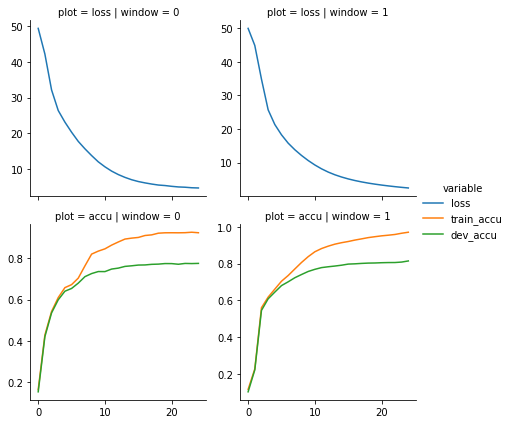

In [21]:
plot_loss_accu([df_w0, df_w1], window_list=[0, 1])

In [ ]:
plot_confusion_matrix(conf_matrix_w0, all_labels_devtest, 'w=0')

In [ ]:
plot_confusion_matrix(conf_matrix_w0, all_labels_devtest, 'w=1')

# 2. Feature Engineering
In addition to the following binary features, I also added a count feature for digits and a count feature for the length of the entire token.

In [ ]:
FEATURES = ['#', '%', "'", '/', ':', '’']

In [ ]:
X_train_features = construct_features(train, FEATURES)

In [ ]:
X_train_features.shape

# 3. Pretrained Embeddings

In [ ]:
# construct maps for pretrained word embs

# 4. Architecture Engineering
## w = 2

In [ ]:
# w = 2
X_train_w2 = encode_lines(train, word2idx_rand, window_size=2)
X_dev_w2 = encode_lines(dev, word2idx_rand, window_size=2)
X_devtest_w2 = encode_lines(devtest, word2idx_rand, window_size=2)